In [1]:
!pip install scikit-learn pandas matplotlib seaborn


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

# PyTorch 라이브러리
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# 데이터 스케일링 및 모델 평가
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from tqdm import tqdm

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

In [2]:
# GPU 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 가능한 장치: {device}")

# 여러 개의 GPU 사용 여부 확인
if torch.cuda.device_count() > 1:
    print(f"{torch.cuda.device_count()} 개의 GPU를 사용합니다.")
else:
    print("단일 GPU 또는 CPU를 사용합니다.")

사용 가능한 장치: cuda
2 개의 GPU를 사용합니다.


In [ ]:
# 데이터 로드
data = pd.read_csv('C:\Users\jymin\OneDrive - UNIST (1)\AI-Factory 경진대회\task2_data\Task2_data.csv', parse_dates=['Timestamp'])
data.sort_values('Timestamp', inplace=True)
data.reset_index(drop=True, inplace=True)

# 타임스탬프를 인덱스로 설정
data.set_index('Timestamp', inplace=True)

# 결측치 보간 (선형 보간법)
data.interpolate(method='linear', inplace=True)

In [4]:
# 공정별 총 입력, 정상, 불량 수량 계산
for process in ['P1', 'P2', 'P3']:
    cols_inItems = [col for col in data.columns if process in col and 'inItems' in col]
    cols_NOR = [col for col in data.columns if process in col and 'NOR' in col]
    cols_DEF = [col for col in data.columns if process in col and 'DEF' in col]
    
    data[f'{process}_total_inItems'] = data[cols_inItems].sum(axis=1)
    data[f'{process}_total_NOR'] = data[cols_NOR].sum(axis=1)
    data[f'{process}_total_DEF'] = data[cols_DEF].sum(axis=1)
    
    # 불량률 계산
    data[f'{process}_def_rate'] = data[f'{process}_total_DEF'] / data[f'{process}_total_inItems']
    
    # 변화율 계산
    data[f'{process}_inItems_diff'] = data[f'{process}_total_inItems'].diff()
    data[f'{process}_inItems_pct_change'] = data[f'{process}_total_inItems'].pct_change()
    
    # 이동 평균 및 이동 표준편차 (window=5)
    data[f'{process}_inItems_ma'] = data[f'{process}_total_inItems'].rolling(window=5).mean()
    data[f'{process}_inItems_std'] = data[f'{process}_total_inItems'].rolling(window=5).std()
    
    # 지연 변수 (lag=1)
    data[f'{process}_inItems_lag1'] = data[f'{process}_total_inItems'].shift(1)

# 결측치 재처리 (새로운 변수에서 발생한 결측치)
data.fillna(method='bfill', inplace=True)
data.fillna(method='ffill', inplace=True)

/tmp/ipykernel_60463/3020211695.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)
/tmp/ipykernel_60463/3020211695.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [5]:
# 사용할 특성 선택
features = data.columns

# 스케일링
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[features])

# 스케일링된 데이터를 데이터프레임으로 변환
data_scaled = pd.DataFrame(data_scaled, columns=features, index=data.index)

# 시퀀스 길이 설정
TIME_STEPS = 30  # 30개의 타임스텝 사용

def create_sequences(data, time_steps=TIME_STEPS):
    sequences = []
    for i in range(len(data) - time_steps):
        seq = data.iloc[i:(i + time_steps)].values
        sequences.append(seq)
    return np.array(sequences)

# 시퀀스 데이터 생성
sequences = create_sequences(data_scaled)

In [6]:
class SequenceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)

    def __len__(self):
        return self.sequences.shape[0]

    def __getitem__(self, idx):
        return self.sequences[idx]

# 데이터셋 및 데이터로더 생성
dataset = SequenceDataset(sequences)
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [11]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=128):
        super(LSTMAutoencoder, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.embedding_dim = embedding_dim

        # 인코더
        self.encoder = nn.LSTM(
            input_size=n_features,
            hidden_size=embedding_dim,
            num_layers=2,
            batch_first=True
        )

        # 디코더
        self.decoder = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=embedding_dim,
            num_layers=2,
            batch_first=True
        )

        # 출력 레이어
        self.output_layer = nn.Linear(embedding_dim, n_features)

    def forward(self, x):
        # 인코더
        _, (hidden, cell) = self.encoder(x)

        # 디코더 입력 초기화 (0으로 채워진 텐서)
        decoder_input = torch.zeros(x.size(0), self.seq_len, self.embedding_dim).to(x.device)

        # 디코더
        x_decoded, _ = self.decoder(decoder_input, (hidden, cell))

        # 출력 레이어를 통해 원래 특성 차원으로 변환
        x_decoded = self.output_layer(x_decoded)

        return x_decoded

# 모델 인스턴스 생성
seq_len = TIME_STEPS
n_features = sequences.shape[2]
model = LSTMAutoencoder(seq_len, n_features, embedding_dim=128)

In [12]:
# 모델을 지정된 장치로 이동
model.to(device)

# 여러 GPU 사용 설정
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [13]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [14]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    epoch_losses = []
    # tqdm을 사용한 학습 진행 상황 모니터링
    with tqdm(total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
        for batch in dataloader:
            batch = batch.to(device)
            optimizer.zero_grad()
            # 입력과 타겟이 동일 (오토인코더)
            output = model(batch)
            loss = criterion(output, batch)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
            pbar.set_postfix({'Loss': np.mean(epoch_losses)})
            pbar.update(1)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(epoch_losses):.6f}")

Epoch 1/100: 100%|██████████| 1643/1643 [00:18<00:00, 86.96it/s, Loss=0.000913]


Epoch [1/100], Loss: 0.000913


Epoch 2/100: 100%|██████████| 1643/1643 [00:18<00:00, 88.64it/s, Loss=0.00101] 


Epoch [2/100], Loss: 0.001014


Epoch 3/100: 100%|██████████| 1643/1643 [00:18<00:00, 88.90it/s, Loss=0.000494]


Epoch [3/100], Loss: 0.000494


Epoch 4/100: 100%|██████████| 1643/1643 [00:18<00:00, 89.19it/s, Loss=0.000414]


Epoch [4/100], Loss: 0.000414


Epoch 5/100: 100%|██████████| 1643/1643 [00:18<00:00, 88.45it/s, Loss=0.00038] 


Epoch [5/100], Loss: 0.000380


Epoch 6/100: 100%|██████████| 1643/1643 [00:18<00:00, 88.50it/s, Loss=0.000387]


Epoch [6/100], Loss: 0.000387


Epoch 7/100: 100%|██████████| 1643/1643 [00:18<00:00, 89.32it/s, Loss=0.000397]


Epoch [7/100], Loss: 0.000397


Epoch 8/100: 100%|██████████| 1643/1643 [00:18<00:00, 89.11it/s, Loss=0.000382]


Epoch [8/100], Loss: 0.000382


Epoch 9/100: 100%|██████████| 1643/1643 [00:18<00:00, 89.22it/s, Loss=0.000386]


Epoch [9/100], Loss: 0.000386


Epoch 10/100: 100%|██████████| 1643/1643 [00:18<00:00, 89.32it/s, Loss=0.000376]


Epoch [10/100], Loss: 0.000376


Epoch 11/100: 100%|██████████| 1643/1643 [00:18<00:00, 89.35it/s, Loss=0.000372]


Epoch [11/100], Loss: 0.000372


Epoch 12/100: 100%|██████████| 1643/1643 [00:18<00:00, 88.91it/s, Loss=0.000379]


Epoch [12/100], Loss: 0.000379


Epoch 13/100: 100%|██████████| 1643/1643 [00:18<00:00, 89.29it/s, Loss=0.000377]


Epoch [13/100], Loss: 0.000377


Epoch 14/100: 100%|██████████| 1643/1643 [00:18<00:00, 89.06it/s, Loss=0.000378]


Epoch [14/100], Loss: 0.000378


Epoch 15/100: 100%|██████████| 1643/1643 [00:18<00:00, 87.74it/s, Loss=0.00037] 


Epoch [15/100], Loss: 0.000370


Epoch 16/100: 100%|██████████| 1643/1643 [00:18<00:00, 88.64it/s, Loss=0.000378]


Epoch [16/100], Loss: 0.000378


Epoch 17/100: 100%|██████████| 1643/1643 [00:18<00:00, 88.69it/s, Loss=0.000366]


Epoch [17/100], Loss: 0.000366


Epoch 18/100: 100%|██████████| 1643/1643 [00:18<00:00, 88.71it/s, Loss=0.000362]


Epoch [18/100], Loss: 0.000362


Epoch 19/100: 100%|██████████| 1643/1643 [00:18<00:00, 87.78it/s, Loss=0.000349]


Epoch [19/100], Loss: 0.000349


Epoch 20/100: 100%|██████████| 1643/1643 [00:18<00:00, 88.92it/s, Loss=0.000334]


Epoch [20/100], Loss: 0.000334


Epoch 21/100: 100%|██████████| 1643/1643 [00:18<00:00, 87.95it/s, Loss=0.000323]


Epoch [21/100], Loss: 0.000323


Epoch 22/100: 100%|██████████| 1643/1643 [00:19<00:00, 85.88it/s, Loss=0.000308]


Epoch [22/100], Loss: 0.000308


Epoch 23/100: 100%|██████████| 1643/1643 [00:19<00:00, 83.08it/s, Loss=0.000304]


Epoch [23/100], Loss: 0.000304


Epoch 24/100: 100%|██████████| 1643/1643 [00:19<00:00, 85.93it/s, Loss=0.000292]


Epoch [24/100], Loss: 0.000292


Epoch 25/100: 100%|██████████| 1643/1643 [00:19<00:00, 85.89it/s, Loss=0.000285]


Epoch [25/100], Loss: 0.000285


Epoch 26/100: 100%|██████████| 1643/1643 [00:18<00:00, 87.67it/s, Loss=0.000279]


Epoch [26/100], Loss: 0.000279


Epoch 27/100: 100%|██████████| 1643/1643 [00:18<00:00, 88.52it/s, Loss=0.000277]


Epoch [27/100], Loss: 0.000277


Epoch 28/100: 100%|██████████| 1643/1643 [00:18<00:00, 89.13it/s, Loss=0.000271]


Epoch [28/100], Loss: 0.000271


Epoch 29/100: 100%|██████████| 1643/1643 [00:18<00:00, 88.75it/s, Loss=0.000286]


Epoch [29/100], Loss: 0.000286


Epoch 30/100: 100%|██████████| 1643/1643 [00:18<00:00, 87.79it/s, Loss=0.000283]


Epoch [30/100], Loss: 0.000283


Epoch 31/100: 100%|██████████| 1643/1643 [00:18<00:00, 88.34it/s, Loss=0.000271]


Epoch [31/100], Loss: 0.000271


Epoch 32/100: 100%|██████████| 1643/1643 [00:18<00:00, 88.98it/s, Loss=0.000268]


Epoch [32/100], Loss: 0.000268


Epoch 33/100: 100%|██████████| 1643/1643 [00:18<00:00, 88.31it/s, Loss=0.000267]


Epoch [33/100], Loss: 0.000267


Epoch 34/100: 100%|██████████| 1643/1643 [00:19<00:00, 85.42it/s, Loss=0.000263]


Epoch [34/100], Loss: 0.000263


Epoch 35/100: 100%|██████████| 1643/1643 [00:19<00:00, 84.24it/s, Loss=0.000297]


Epoch [35/100], Loss: 0.000297


Epoch 36/100: 100%|██████████| 1643/1643 [00:18<00:00, 88.17it/s, Loss=0.000251]


Epoch [36/100], Loss: 0.000251


Epoch 37/100: 100%|██████████| 1643/1643 [00:18<00:00, 87.76it/s, Loss=0.000259]


Epoch [37/100], Loss: 0.000259


Epoch 38/100: 100%|██████████| 1643/1643 [00:18<00:00, 87.99it/s, Loss=0.000252]


Epoch [38/100], Loss: 0.000252


Epoch 39/100: 100%|██████████| 1643/1643 [00:18<00:00, 87.44it/s, Loss=0.000249]


Epoch [39/100], Loss: 0.000249


Epoch 40/100: 100%|██████████| 1643/1643 [00:19<00:00, 84.88it/s, Loss=0.000255]


Epoch [40/100], Loss: 0.000255


Epoch 41/100: 100%|██████████| 1643/1643 [00:19<00:00, 84.58it/s, Loss=0.000255]


Epoch [41/100], Loss: 0.000255


Epoch 42/100: 100%|██████████| 1643/1643 [00:19<00:00, 86.46it/s, Loss=0.000247]


Epoch [42/100], Loss: 0.000247


Epoch 43/100: 100%|██████████| 1643/1643 [00:19<00:00, 85.85it/s, Loss=0.000244]


Epoch [43/100], Loss: 0.000244


Epoch 44/100: 100%|██████████| 1643/1643 [00:18<00:00, 86.73it/s, Loss=0.000257]


Epoch [44/100], Loss: 0.000257


Epoch 45/100: 100%|██████████| 1643/1643 [00:19<00:00, 83.90it/s, Loss=0.000243]


Epoch [45/100], Loss: 0.000243


Epoch 46/100: 100%|██████████| 1643/1643 [00:19<00:00, 85.70it/s, Loss=0.000254]


Epoch [46/100], Loss: 0.000254


Epoch 47/100: 100%|██████████| 1643/1643 [00:19<00:00, 85.61it/s, Loss=0.000245]


Epoch [47/100], Loss: 0.000245


Epoch 48/100: 100%|██████████| 1643/1643 [00:19<00:00, 85.35it/s, Loss=0.000243]


Epoch [48/100], Loss: 0.000243


Epoch 49/100: 100%|██████████| 1643/1643 [00:19<00:00, 82.71it/s, Loss=0.000248]


Epoch [49/100], Loss: 0.000248


Epoch 50/100: 100%|██████████| 1643/1643 [00:20<00:00, 80.78it/s, Loss=0.000237]


Epoch [50/100], Loss: 0.000237


Epoch 51/100:  30%|███       | 497/1643 [00:06<00:14, 80.46it/s, Loss=0.000239]


KeyboardInterrupt: 

In [15]:
# 전체 데이터에 대한 재구성 오차 계산
model.eval()
reconstruction_errors = []

with torch.no_grad():
    with tqdm(total=len(dataloader), desc="Calculating Reconstruction Errors") as pbar:
        for batch in dataloader:
            batch = batch.to(device)
            output = model(batch)
            loss = torch.mean((output - batch) ** 2, dim=(1, 2))
            reconstruction_errors.extend(loss.cpu().numpy())
            pbar.update(1)

Calculating Reconstruction Errors: 100%|██████████| 1643/1643 [00:16<00:00, 99.72it/s] 


In [17]:
torch.save(model.state_dict(), "./model.pth")

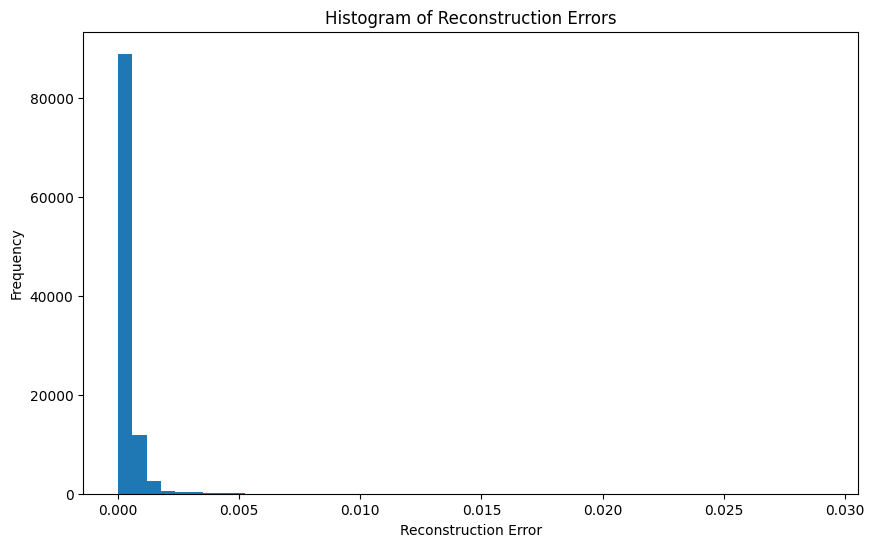

설정된 임계값: 0.0027898737462237477


In [18]:
# 재구성 오차의 분포 시각화
plt.figure(figsize=(10,6))
plt.hist(reconstruction_errors, bins=50)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Errors')
plt.show()

# 임계값 설정 (평균 + 3표준편차)
threshold = np.mean(reconstruction_errors) + 3 * np.std(reconstruction_errors)
print(f'설정된 임계값: {threshold}')

# 이상치 여부 판단
anomalies = reconstruction_errors > threshold

# 이상치 인덱스 매핑
anomaly_indices = []
for i in range(len(anomalies)):
    if anomalies[i]:
        anomaly_indices.append(data.index[i + TIME_STEPS])

# 전체 시점에 대한 이상치 여부 생성
data['Anomaly'] = 0
data.loc[anomaly_indices, 'Anomaly'] = 1

In [19]:
# 결과 저장
result = data[['Anomaly']].reset_index()
result.to_csv('./task2/answer_sample.csv', index=False)

In [21]:
result['Anomaly'].value_counts()

Anomaly
0    104222
1       898
Name: count, dtype: int64